# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## HomeWork 05

Давайте попробуем сделать простую реккурентную нейронную сеть, которая будет учиться складывать числа. Для этих целей мы не будем пользоваться фреймворками для Deep Learning, чтобы посмотреть как она работает внутри.


In [66]:
import matplotlib.pyplot as plt

def show_stats(hist, score):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    print(f"Лучшее кол-во эпох: {np.argmax(hist.history['val_accuracy'])+1} \
          accuracy = {np.max(hist.history['val_accuracy'])}")
#     print(f"Test accuracy: {score[1]}")

Теперь давайте попробуем с помощью Keras построить LSTM нейронную сеть для оценки настроений отзвывов на IMD.

Данный датасет слишком мал, чтобы преимущества LSTM проявились, однако в учебных целях он подойдет.

В тренировке рекуррентных нейронных сетей важную роль играет размер batch, но еще большую роль играет выбор функций loss и optimizer.

In [92]:
%%time
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers import LSTM
from keras.datasets import imdb
from keras import optimizers


max_features = 20000

# обрезание текстов после данного количества слов (среди top max_features наиболее используемые слова)
maxlen = 100
batch_size = 100 # увеличьте значение для ускорения обучения
num_epoch = 5

print('Загрузка данных...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'тренировочные последовательности')
print(len(x_test), 'тестовые последовательности')

print('Pad последовательности (примеров в x единицу времени)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Построение модели...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))  
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))  
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))

model.add(Dense(256, activation='relu', name='FC1'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# стоит попробовать использовать другие оптимайзер и другие конфигурации оптимайзеров 
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
#               optimizer=optimizers.Nadam(learning_rate=0.001),
#               optimizer='adamax',
              metrics=['accuracy'])

print('Процесс обучения...')
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch, # увеличьте при необходимости
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Результат при тестировании:', score)
print('Тестовая точность:', acc)


Загрузка данных...
25000 тренировочные последовательности
25000 тестовые последовательности
Pad последовательности (примеров в x единицу времени)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Построение модели...
Процесс обучения...


d:\_ds_\_env_\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 67s 3ms/step - loss: 0.5583 - accuracy: 0.7138 - val_loss: 0.3745 - val_accuracy: 0.8358
Epoch 2/5
25000/25000 [==============================] - 70s 3ms/step - loss: 0.3601 - accuracy: 0.8546 - val_loss: 0.3498 - val_accuracy: 0.8463
Epoch 3/5
25000/25000 [==============================] - 66s 3ms/step - loss: 0.2969 - accuracy: 0.8826 - val_loss: 0.3461 - val_accuracy: 0.8534
Epoch 4/5
25000/25000 [==============================] - 64s 3ms/step - loss: 0.2534 - accuracy: 0.9034 - val_loss: 0.3603 - val_accuracy: 0.8548
Epoch 5/5
25000/25000 [==============================] - 11s 429us/step
Результат при тестировании: 0.34452616280317305
Тестовая точность: 0.8550000190734863
Wall time: 5min 49s


Лучшее кол-во эпох: 5           accuracy = 0.8550000190734863


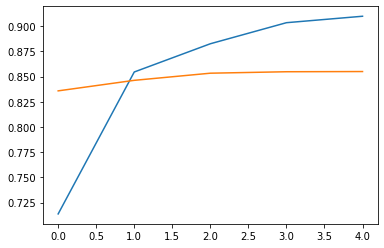

In [93]:
show_stats(hist, score)

### Мои наблюдения по LSTM

<ol>
    <li>Увеличение maxlen до 100 помогло увеличить точность</li>
    <li>Размер батча повел себя интересно: при простых сетях уменьшение батча увеличивало качество, при усложнении сети батч меньше 100 приводил к ухудшению</li>
    <li>Оптимизатор и его параметры не особенно сказались на точности системы (перебрал adam, adamax, RMSprop, Nadam </li>
    <li>Добавление стекинга с дополнительными LTSM слоями стабилизировали результаты и немного увеличил точность</li>
    <li>Добавление дополнительной комбинации денс слоя с дропаутом позволили обучаться дальше 1 эпохи и также повысили точность </li>
</ol>

### Часть 2 - генератор GRU

Давайте также посмотрим пример в котором будет использоваться другой класс задач - генерация текста на основе тренировочного текста. В задачу нейросети будет входить обучившись на тексте Алиса в стране чудес и начать генерировать текст похожий на тот, что можно встретить в этой книге. Также в этом примере будет использоваться GRU.

In [1]:
%%time

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.utils import multi_gpu_model

tf.debugging.set_log_device_placement(True)

FILE = "МастерМаргарита.txt"

# построчное чтение из примера с текстом 
with open(FILE, 'rb') as _in:
    lines = []
    for line in _in:
        line = line.strip().lower().decode("utf8", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
chars = set([c for c in text])
nb_chars = len(chars)


# создание индекса символов и reverse mapping чтобы передвигаться между значениями numerical
# ID and a specific character. The numerical ID will correspond to a column
# ID и определенный символ. Numerical ID будет соответсвовать колонке
# число при использовании one-hot кодировки для представление входов символов
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}

# для удобства выберете фиксированную длину последовательность 10 символов 
SEQLEN, STEP = 10, 1
input_chars, label_chars = [], []

# конвертация data в серии разных SEQLEN-length субпоследовательностей
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i: i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


# Вычисление one-hot encoding входных последовательностей X и следующего символа (the label) y

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1


# установка ряда метапамертров  для нейронной сети и процесса тренировки
BATCH_SIZE, HIDDEN_SIZE = 256, 512
NUM_ITERATIONS = 50 # 25 должно быть достаточно
NUM_EPOCHS_PER_ITERATION = 2
NUM_PREDS_PER_EPOCH = 100


# Create a super simple recurrent neural network. There is one recurrent
# layer that produces an embedding of size HIDDEN_SIZE from the one-hot
# encoded input layer. This is followed by a Dense fully-connected layer
# across the set of possible next characters, which is converted to a
# probability score via a standard softmax activation with a multi-class
# cross-entropy loss function linking the prediction to the one-hot
# encoding character label.

'''
Создание очень простой рекуррентной нейронной сети. 
В ней будет один реккурентный закодированный входной слой. 
За ним последует полносвязный слой связанный с набором возможных следующих символов, которые конвертированы в вероятностные результаты 
через стандартную softmax активацию с multi-class cross-encoding loss функцию 
ссылающуются на предсказание one-hot encoding лейбл символа
'''
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

model = Sequential()
model.add(
    GRU(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(SEQLEN, nb_chars),
        unroll=True
    )
)
#   model.add(LSTM(HIDDEN_SIZE, dropout=0.3, recurrent_dropout=0.2, return_sequences=False)) 
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")




Using TensorFlow backend.


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/t

In [2]:
# выполнение серий тренировочных и демонстрационных итераций 

for iteration in range(NUM_ITERATIONS):

    # для каждой итерации запуск передачи данных в модель 
    print("=" * 50)
    print("Итерация #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Select a random example input sequence.
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    # для числа шагов предсказаний использование текущей тренируемой модели 
    # конструирование one-hot encoding для тестирования input и добавление предсказания.
    print("Генерация из посева: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):

        # здесь one-hot encoding.
        X_test = np.zeros((1, SEQLEN, nb_chars))
        for j, ch in enumerate(test_chars):
            X_test[0, j, char2index[ch]] = 1

        # осуществление предсказания с помощью текущей модели.
        pred = model.predict(X_test, verbose=0)[0]
        y_pred = index2char[np.argmax(pred)]

        # вывод предсказания добавленного к тестовому примеру 
        print(y_pred, end="")

        # инкрементация тестового примера содержащего предсказание
        test_chars = test_chars[1:] + y_pred
        
print()



Итерация #: 0
Epoch 1/2
Executing op __inference_keras_scratch_graph_3530 in device /job:localhost/replica:0/task:0/device:GPU:0
752033/752033 [==============================] - 36s 47us/step - loss: 2.1921
Epoch 2/2
752033/752033 [==============================] - 29s 39us/step - loss: 1.7670
Генерация из посева: было стуль
было стульExecuting op __inference_keras_scratch_graph_27547 in device /job:localhost/replica:0/task:0/device:GPU:0
 в котором с нем доманного стал совершенно не было стал совершенно не было стал совершенно не было с==================================================
Итерация #: 1
Epoch 1/2
752033/752033 [==============================] - 29s 39us/step - loss: 1.6089
Epoch 2/2
752033/752033 [==============================] - 29s 39us/step - loss: 1.5135
Генерация из посева: еменно быт
еменно быть с ним под комнате в свой от столо в кабинет под котором он поднял свой притурельный под котором он==================================================
Итерация #: 2
Epoch 1/2

## Мои наблюдения за GRU

<ol>
    <li>Уже что то получилось</li>
    <li>Закономерность я пока для себя не вывел - но уже есть с чем работать</li>
</ol>